In [138]:
## importing the necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras import models, layers  # Import models and layers from Keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop  # Import RMSprop optimizer
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16

In [ ]:
### loading the dataset
import os, shutil, pathlib

original_dir = pathlib.Path(r"C:\Users\PC\Documents\CSCN8010\CSCN8010-labs\data\train\train")
new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
### loading the dataset
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

In [133]:
### splitting the data into different classes
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [38]:
# Inspect the dataset structure
for images, labels in train_dataset.take(1): 
    print("Images shape:", images.shape) 
    print("Labels shape:", labels.shape)


Images shape: (32, 180, 180, 3)
Labels shape: (32,)


In [39]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

### Exploratory Analysis

Class distribution in training set: Counter({1: 1000, 0: 1000})
Class distribution in validation set: Counter({0: 500, 1: 500})
Class distribution in test set: Counter({1: 1000, 0: 1000})


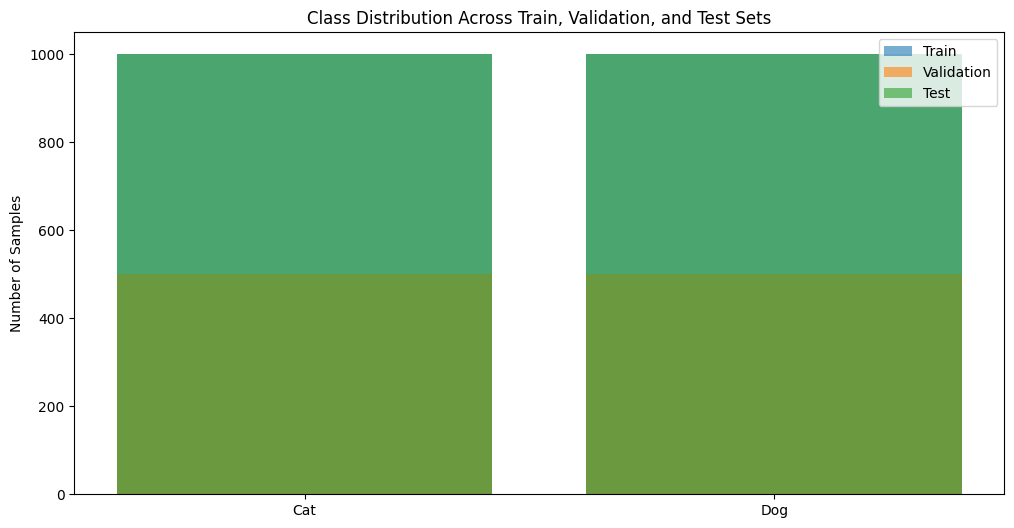

In [40]:
from collections import Counter

## checking data structure and class distribution
# Count the number of samples per class in each dataset
def count_classes(dataset):
    class_counts = Counter()
    for _, labels in dataset:
        class_counts.update(labels.numpy().tolist())
    return class_counts

# Analyze class distribution
train_class_counts = count_classes(train_dataset)
val_class_counts = count_classes(validation_dataset)
test_class_counts = count_classes(test_dataset)

print("Class distribution in training set:", train_class_counts)
print("Class distribution in validation set:", val_class_counts)
print("Class distribution in test set:", test_class_counts)

# Visualize class distribution
import matplotlib.pyplot as plt

labels = ['Cat', 'Dog']
train_counts = [train_class_counts[0], train_class_counts[1]]
val_counts = [val_class_counts[0], val_class_counts[1]]
test_counts = [test_class_counts[0], test_class_counts[1]]

plt.figure(figsize=(12, 6))
plt.bar(labels, train_counts, label='Train', alpha=0.6)
plt.bar(labels, val_counts, label='Validation', alpha=0.6)
plt.bar(labels, test_counts, label='Test', alpha=0.6)
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()


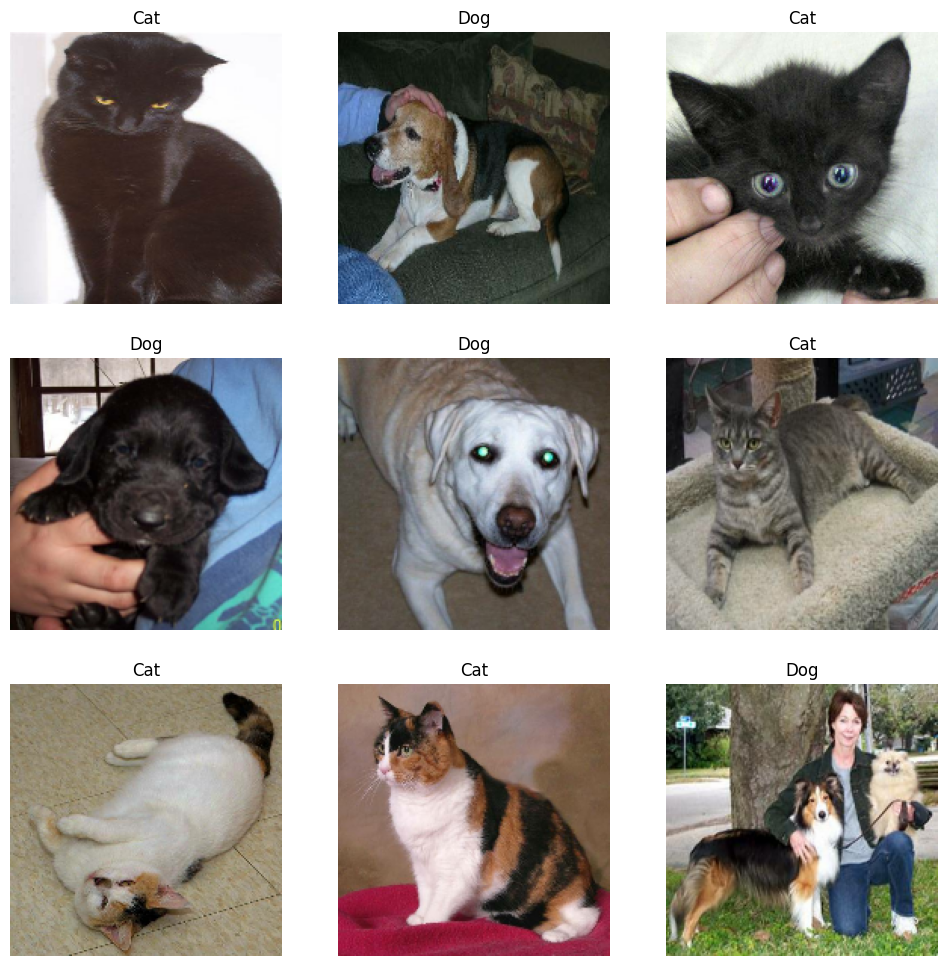

In [41]:
import numpy as np
## visualizing sample images from dataset
# Visualize a few sample images
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title("Cat" if labels[i] == 0 else "Dog")
        plt.axis("off")
    break


Image batch shape: (32, 180, 180, 3)
Min pixel value: 0.0
Max pixel value: 255.0
Mean pixel value: 112.782
Std pixel value: 64.51781


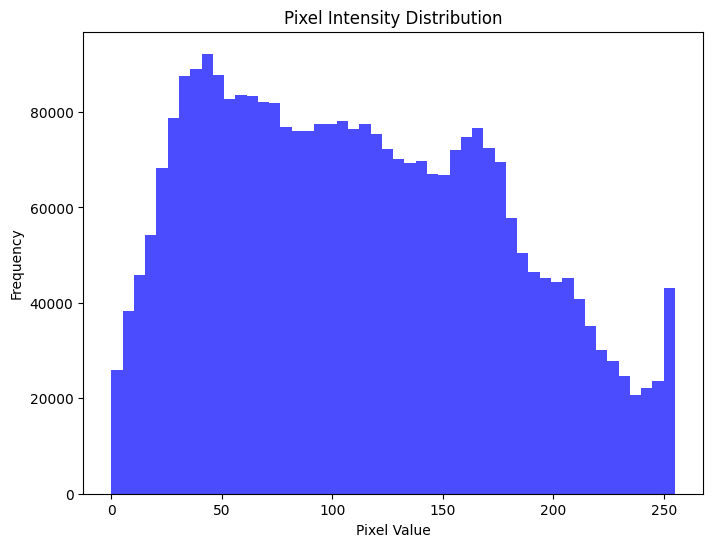

In [42]:
# Analyzing image shapes and pixel intensity ranges
#  Analyze image shapes
for images, _ in train_dataset.take(1):  # Take one batch
    print("Image batch shape:", images.shape)  # Should be (batch_size, height, width, channels)

# Analyze pixel intensity range
for images, _ in train_dataset.take(1):
    pixel_values = images.numpy().ravel()
    print("Min pixel value:", pixel_values.min())
    print("Max pixel value:", pixel_values.max())
    print("Mean pixel value:", pixel_values.mean())
    print("Std pixel value:", pixel_values.std())
    break

# Plot histogram of pixel intensities
plt.figure(figsize=(8, 6))
plt.hist(pixel_values, bins=50, color="blue", alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


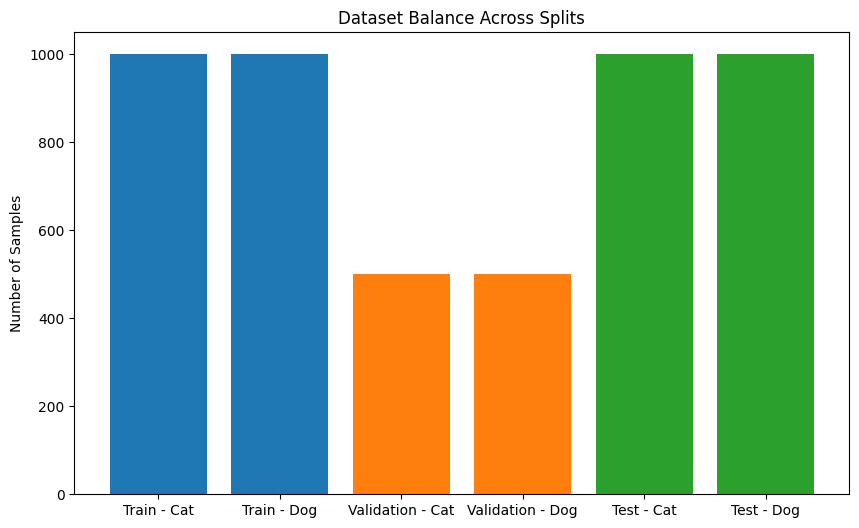

In [43]:
# Visualize dataset balance for training, validation, and test sets
data_splits = ["Train", "Validation", "Test"]
counts = [train_counts, val_counts, test_counts]

plt.figure(figsize=(10, 6))
for i, split in enumerate(data_splits):
    plt.bar([f"{split} - Cat", f"{split} - Dog"], [counts[i][0], counts[i][1]])

plt.title("Dataset Balance Across Splits")
plt.ylabel("Number of Samples")
plt.show()


### Insights and Observation

#### The dataset distribution across the training, validation, and test sets demonstrates a well-balanced dataset.

#### The dataset is balanced across all splits (training, validation, and test), which is ideal for training classification models.
#### There is no need for additional techniques like oversampling, undersampling, or class weighting.
#### Dataset Size:

#### The dataset size is sufficient for training and evaluating a deep learning model.
#### 2000 training samples are a good starting point for a binary classification task, especially with data augmentation.
#### Evaluation Metrics:

#### Since the dataset is balanced, metrics like accuracy and loss will be reliable indicators of performance.

#### The images represent the two classes in the dataset:
#### Cat: Appears in 5 images (Row 1, Column 1; Row 2, Column 2, 3; Row 3, Column 2, 3).
#### Dog: Appears in 4 images (Row 1, Column 2, 3; Row 2, Column 1; Row 3, Column 1).
#### Each image is appropriately labeled, showing a clear distinction between the two classes. Variations in Backgrounds:
#### Some images have plain or blurred backgrounds (e.g., Row 1, Column 3).
#### Others include human interaction or indoor settings (e.g., Row 1, Column 1; Row 2, Column 2).

#### Augmentation:
#### Techniques like flipping, rotation, zooming, and brightness adjustment can help the model handle variations in poses, lighting, and orientations.
#### Normalization:
#### Scaling pixel values to [0, 1] ensures consistent input for the model.

### Defining the CNN Model

In [44]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
## statistical summary of the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [46]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
## saving best model in a callback before data augumentation
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only= True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 121s 2s/step - loss: 0.6975 - accuracy: 0.5150 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 120s 2s/step - loss: 0.6970 - accuracy: 0.5255 - val_loss: 0.6890 - val_accuracy: 0.5080
Epoch 3/30
63/63 [==============================] - 150s 2s/step - loss: 0.6774 - accuracy: 0.5865 - val_loss: 0.6920 - val_accuracy: 0.5470
Epoch 4/30
63/63 [==============================] - 141s 2s/step - loss: 0.6480 - accuracy: 0.6190 - val_loss: 0.6458 - val_accuracy: 0.6430
Epoch 5/30
63/63 [==============================] - 138s 2s/step - loss: 0.6308 - accuracy: 0.6565 - val_loss: 0.6297 - val_accuracy: 0.6330
Epoch 6/30
63/63 [==============================] - 119s 2s/step - loss: 0.5873 - accuracy: 0.6885 - val_loss: 0.6555 - val_accuracy: 0.5900
Epoch 7/30
63/63 [==============================] - 128s 2s/step - loss: 0.5496 - accuracy: 0.7220 - val_loss: 0.5827 - val_accuracy: 0.7000
Epoch 8/30
63

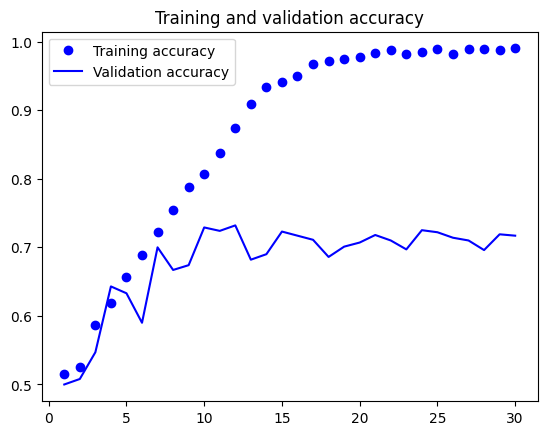

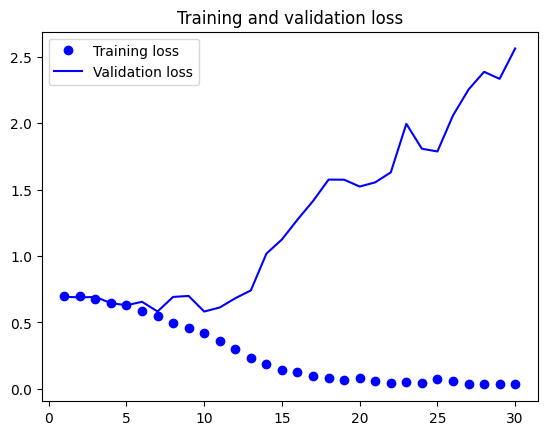

In [ ]:
## plotting the graph of validation to test for over fitting
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [63]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 22s 343ms/step - loss: 0.5936 - accuracy: 0.7300
Test accuracy: 0.730


### Data augumentation for CNN

In [134]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

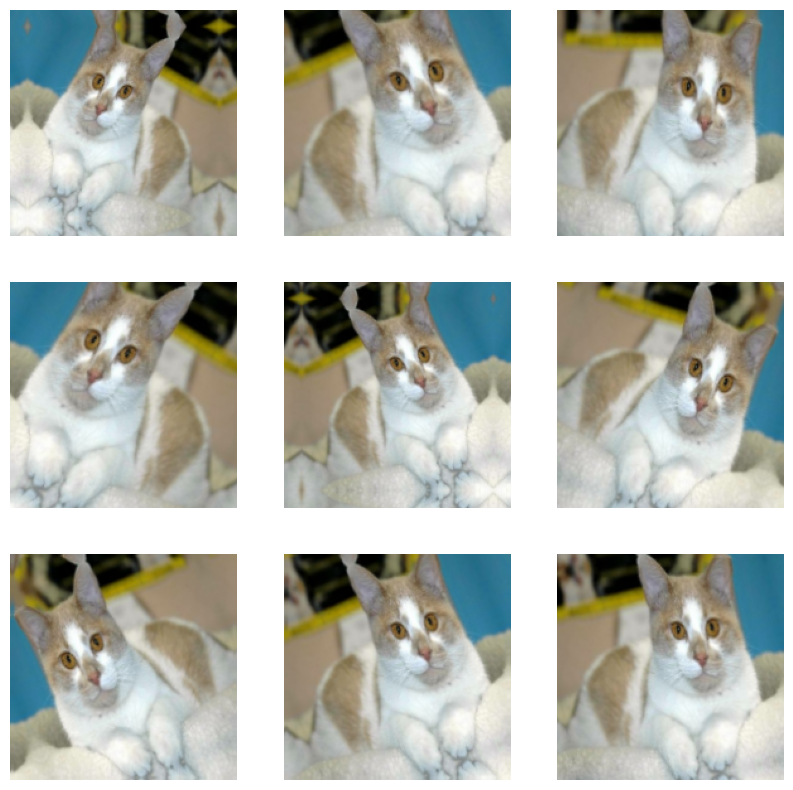

In [135]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [136]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [77]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
## Saving bnest model after data augumentation
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 137s 2s/step - loss: 0.6935 - accuracy: 0.5045 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 139s 2s/step - loss: 0.6943 - accuracy: 0.5185 - val_loss: 0.6887 - val_accuracy: 0.5060
Epoch 3/100
63/63 [==============================] - 163s 3s/step - loss: 0.6911 - accuracy: 0.5690 - val_loss: 0.6730 - val_accuracy: 0.6150
Epoch 4/100
63/63 [==============================] - 145s 2s/step - loss: 0.6805 - accuracy: 0.5955 - val_loss: 0.6790 - val_accuracy: 0.5210
Epoch 5/100
63/63 [==============================] - 130s 2s/step - loss: 0.6538 - accuracy: 0.6295 - val_loss: 0.6542 - val_accuracy: 0.5670
Epoch 6/100
63/63 [==============================] - 131s 2s/step - loss: 0.6387 - accuracy: 0.6320 - val_loss: 0.5987 - val_accuracy: 0.7040
Epoch 7/100
63/63 [==============================] - 131s 2s/step - loss: 0.6349 - accuracy: 0.6515 - val_loss: 0.5904 - val_accuracy: 0.6710
Epoch 

In [113]:
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 23s 345ms/step - loss: 0.4094 - accuracy: 0.8185
Test accuracy: 0.818


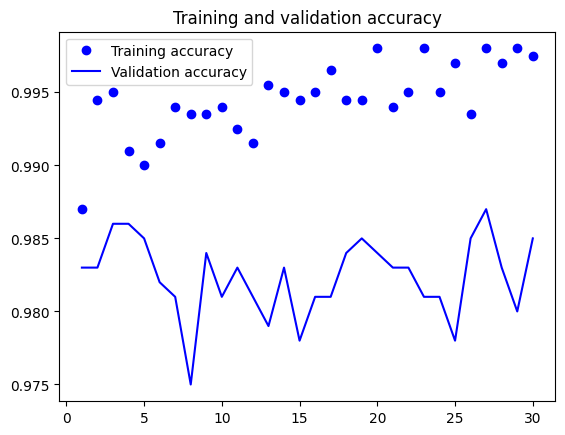

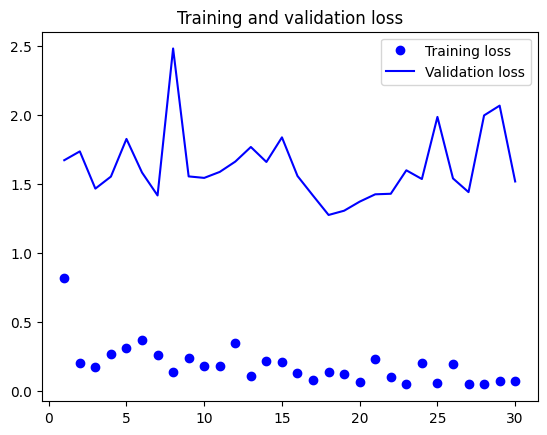

In [ ]:
## plotting the validation graph to test for overfitting
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Defining the VGG 16

In [59]:
# Load the VGG16 base model
conv_base = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))


conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [60]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [61]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 3s 3s/step


In [64]:
train_features.shape

(2000, 5, 5, 512)

In [67]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(inputs, outputs)

In [68]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               3277056   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## saving the best vgg model after feature extraction
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model_2.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 42ms/step - loss: 18.7081 - accuracy: 0.9250 - val_loss: 8.9500 - val_accuracy: 0.9530
Epoch 2/20
63/63 [==============================] - 3s 47ms/step - loss: 4.1287 - accuracy: 0.9750 - val_loss: 5.3200 - val_accuracy: 0.9710
Epoch 3/20
63/63 [==============================] - 3s 44ms/step - loss: 2.9608 - accuracy: 0.9800 - val_loss: 5.0919 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 3s 45ms/step - loss: 1.0977 - accuracy: 0.9915 - val_loss: 6.7650 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 3s 44ms/step - loss: 0.4824 - accuracy: 0.9965 - val_loss: 3.8781 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 3s 51ms/step - loss: 0.6690 - accuracy: 0.9935 - val_loss: 5.3692 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 3s 42ms/step - loss: 0.1919 - accuracy: 0.9980 - val_loss: 5.7011 - val_accuracy: 0.9680
Epoch 8/20
6

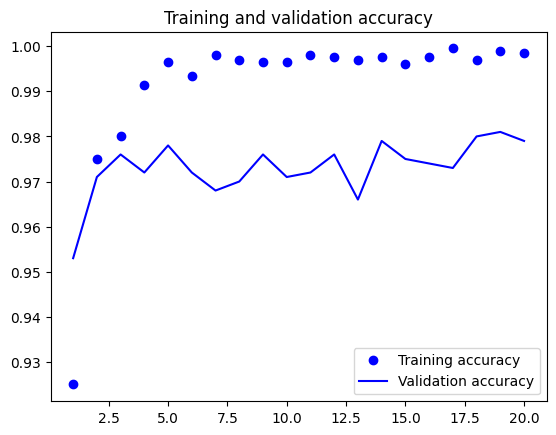

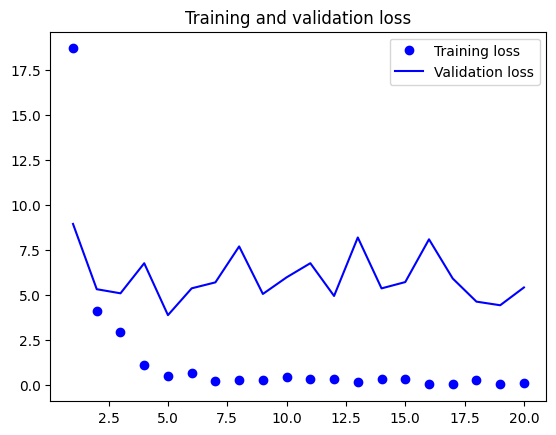

In [ ]:
## plotting validation to test for overfitting
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [107]:
test_model_2 = keras.models.load_model(
    "./models/feature_extraction.keras")
test_loss, test_acc = test_model_2.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 6ms/step - loss: 4.9087 - accuracy: 0.9720
Test accuracy: 0.972


### data augumentation for vgg16

In [78]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [79]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [95]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [96]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(inputs, outputs)

In [97]:
model_2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_13 (Flatten)        (None, 12800)             0  

In [ ]:
model_2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## saving the best vgg16 model after data augumentation.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 592s 9s/step - loss: 20.6140 - accuracy: 0.8900 - val_loss: 4.0610 - val_accuracy: 0.9670
Epoch 2/50
63/63 [==============================] - 597s 9s/step - loss: 7.0461 - accuracy: 0.9445 - val_loss: 4.5346 - val_accuracy: 0.9640
Epoch 3/50
63/63 [==============================] - 602s 10s/step - loss: 5.1694 - accuracy: 0.9550 - val_loss: 5.2695 - val_accuracy: 0.9680
Epoch 4/50
63/63 [==============================] - 603s 10s/step - loss: 6.4113 - accuracy: 0.9550 - val_loss: 5.5086 - val_accuracy: 0.9680
Epoch 5/50
63/63 [==============================] - 596s 9s/step - loss: 3.7493 - accuracy: 0.9650 - val_loss: 3.3889 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 596s 10s/step - loss: 3.3527 - accuracy: 0.9705 - val_loss: 5.0493 - val_accuracy: 0.9720
Epoch 7/50
63/63 [==============================] - 601s 10s/step - loss: 3.4541 - accuracy: 0.9625 - val_loss: 3.1545 - val_accuracy: 0.9790
Epoch 8/50
63/63 [=

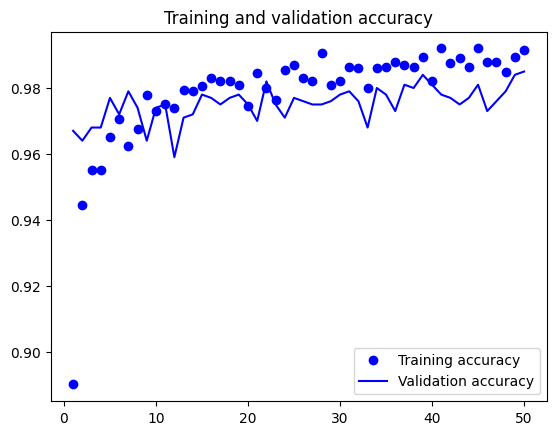

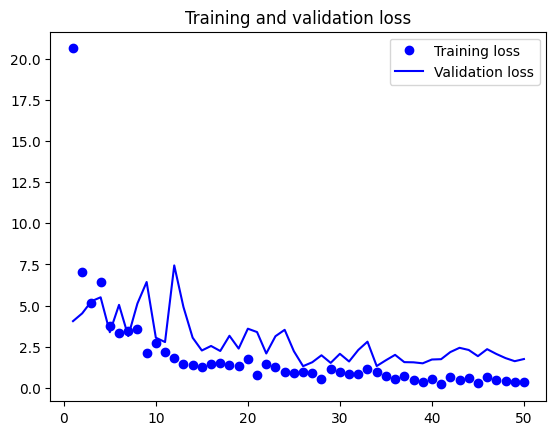

In [ ]:
## plotting validation to test for overfitting
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [108]:
test_model_2 = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model_2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 401s 6s/step - loss: 2.2913 - accuracy: 0.9735
Test accuracy: 0.974


In [102]:
### fine tuning the model

conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [103]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [109]:
model_2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_13 (Flatten)        (None, 12800)             0  

In [ ]:
model_2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

## saving the best model after fine tuning.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_2.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 673s 11s/step - loss: 0.8208 - accuracy: 0.9870 - val_loss: 1.6708 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 673s 11s/step - loss: 0.2035 - accuracy: 0.9945 - val_loss: 1.7347 - val_accuracy: 0.9830
Epoch 3/30
63/63 [==============================] - 666s 11s/step - loss: 0.1723 - accuracy: 0.9950 - val_loss: 1.4650 - val_accuracy: 0.9860
Epoch 4/30
63/63 [==============================] - 672s 11s/step - loss: 0.2701 - accuracy: 0.9910 - val_loss: 1.5522 - val_accuracy: 0.9860
Epoch 5/30
63/63 [==============================] - 678s 11s/step - loss: 0.3114 - accuracy: 0.9900 - val_loss: 1.8250 - val_accuracy: 0.9850
Epoch 6/30
63/63 [==============================] - 671s 11s/step - loss: 0.3650 - accuracy: 0.9915 - val_loss: 1.5817 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 675s 11s/step - loss: 0.2568 - accuracy: 0.9940 - val_loss: 1.4155 - val_accuracy: 0.9810
Epoch 

In [115]:
model_2 = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model_2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 426s 7s/step - loss: 1.6183 - accuracy: 0.9760
Test accuracy: 0.976


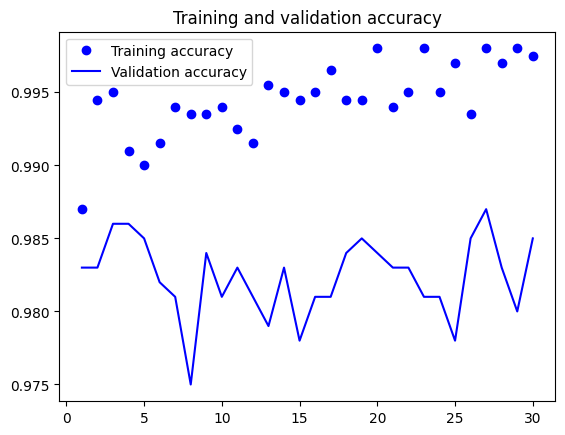

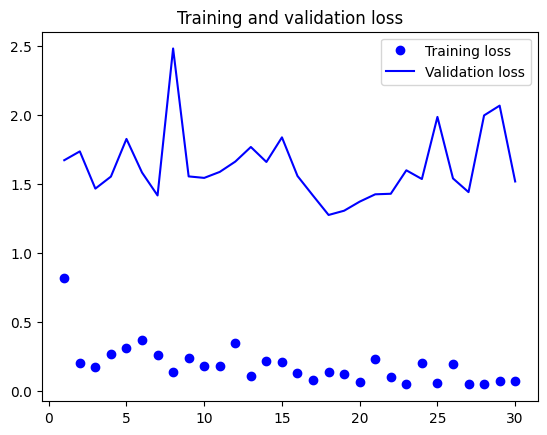

In [ ]:
## plotting validation to test for overfitting
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### evaluation metrics

In [122]:
### loading the best models
model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy for cnn: {test_acc:.3f}")

model_2 = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model_2.evaluate(test_dataset)
print(f"Test accuracy for vgg16: {test_acc:.3f}")


63/63 [==============================] - 27s 431ms/step - loss: 0.4094 - accuracy: 0.8185
Test accuracy for cnn: 0.818
63/63 [==============================] - 401s 6s/step - loss: 1.6183 - accuracy: 0.9760
Test accuracy for vgg16: 0.976


In [ ]:
import numpy as np


# Unbatch the test dataset for predictions
test_images, test_labels = next(iter(test_dataset.unbatch().batch(len(test_dataset))))  # Load all test data

# Generate predictions for Custom CNN
custom_predictions = (model.predict(test_images) > 0.5).astype("int32")

# Generate predictions for Fine-Tuned VGG16
vgg16_predictions = (model_2.predict(test_images) > 0.5).astype("int32")


2/2 [==============================] - 10s 5s/step


Custom CNN - Confusion Matrix:
[[25  4]
 [ 8 26]]
VGG16 Fine-Tuned - Confusion Matrix:
[[29  0]
 [ 1 33]]


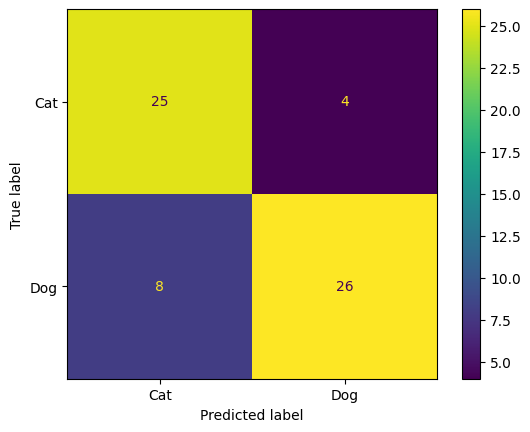

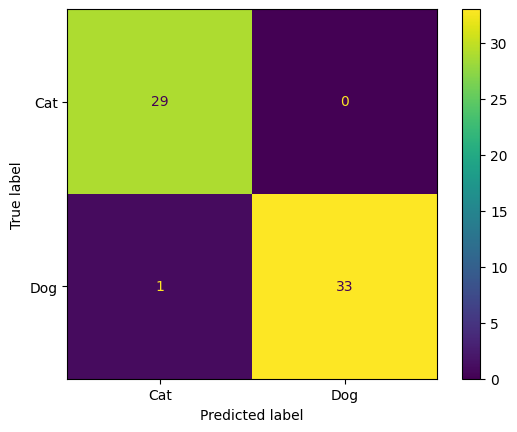

In [127]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Custom CNN
custom_cm = confusion_matrix(test_labels, custom_predictions)
print("Custom CNN - Confusion Matrix:")
print(custom_cm)
ConfusionMatrixDisplay(confusion_matrix=custom_cm, display_labels=["Cat", "Dog"]).plot()

# Confusion Matrix for Fine-Tuned VGG16
vgg16_cm = confusion_matrix(test_labels, vgg16_predictions)
print("VGG16 Fine-Tuned - Confusion Matrix:")
print(vgg16_cm)
ConfusionMatrixDisplay(confusion_matrix=vgg16_cm, display_labels=["Cat", "Dog"]).plot()


In [128]:
from sklearn.metrics import classification_report

# Classification Report for Custom CNN
print("Custom CNN - Classification Report:")
print(classification_report(test_labels, custom_predictions, target_names=["Cat", "Dog"]))

# Classification Report for Fine-Tuned VGG16
print("VGG16 Fine-Tuned - Classification Report:")
print(classification_report(test_labels, vgg16_predictions, target_names=["Cat", "Dog"]))


Custom CNN - Classification Report:
              precision    recall  f1-score   support

         Cat       0.76      0.86      0.81        29
         Dog       0.87      0.76      0.81        34

    accuracy                           0.81        63
   macro avg       0.81      0.81      0.81        63
weighted avg       0.82      0.81      0.81        63

VGG16 Fine-Tuned - Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      1.00      0.98        29
         Dog       1.00      0.97      0.99        34

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.98      0.98      0.98        63



2/2 [==============================] - 10s 5s/step


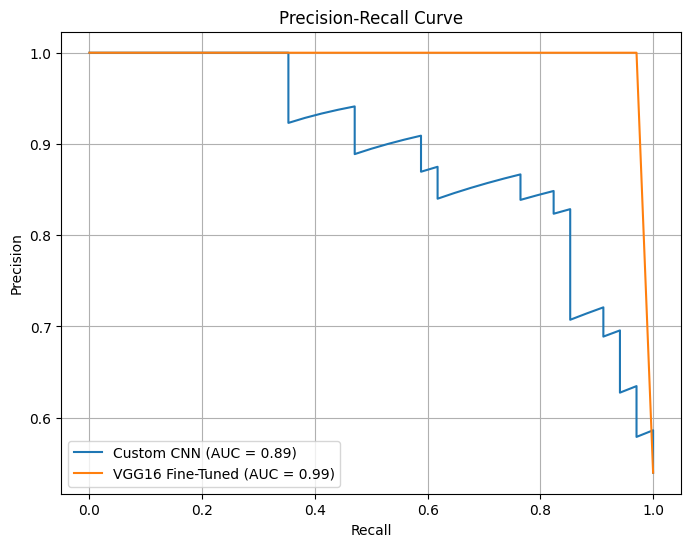

In [129]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Generate probabilities for Precision-Recall Curve
custom_probs = model.predict(test_images).ravel()  # Raw probabilities for Custom CNN
vgg16_probs = model_2.predict(test_images).ravel()  # Raw probabilities for VGG16 Fine-Tuned

# Compute Precision-Recall for Custom CNN
custom_precision, custom_recall, _ = precision_recall_curve(test_labels, custom_probs)
custom_pr_auc = auc(custom_recall, custom_precision)

# Compute Precision-Recall for Fine-Tuned VGG16
vgg16_precision, vgg16_recall, _ = precision_recall_curve(test_labels, vgg16_probs)
vgg16_pr_auc = auc(vgg16_recall, vgg16_precision)

# Plot Precision-Recall Curves
plt.figure(figsize=(8, 6))
plt.plot(custom_recall, custom_precision, label=f'Custom CNN (AUC = {custom_pr_auc:.2f})')
plt.plot(vgg16_recall, vgg16_precision, label=f'VGG16 Fine-Tuned (AUC = {vgg16_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [130]:
### identifying misclassified samples
# Get indices of misclassified samples for Custom CNN
custom_misclassified_indices = np.where(custom_predictions.ravel() != test_labels)[0]

# Get indices of misclassified samples for Fine-Tuned VGG16
vgg16_misclassified_indices = np.where(vgg16_predictions.ravel() != test_labels)[0]

# Display number of misclassified samples
print(f"Custom CNN - Misclassified Samples: {len(custom_misclassified_indices)}")
print(f"VGG16 Fine-Tuned - Misclassified Samples: {len(vgg16_misclassified_indices)}")


Custom CNN - Misclassified Samples: 12
VGG16 Fine-Tuned - Misclassified Samples: 1


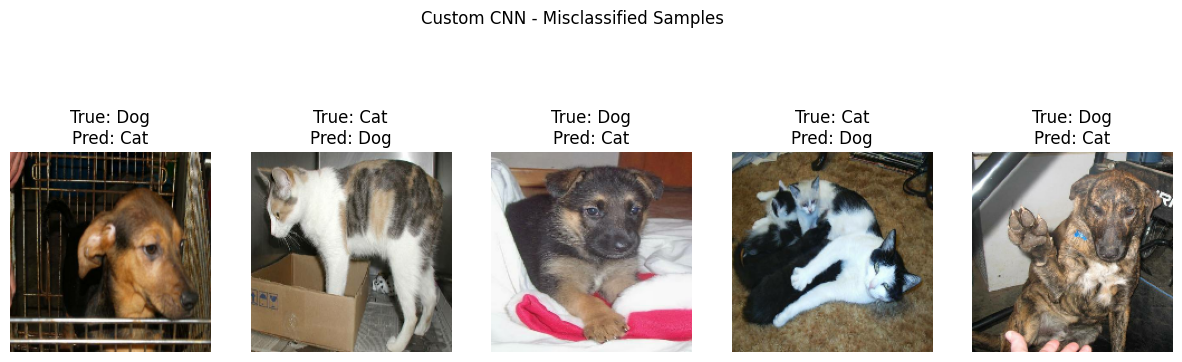

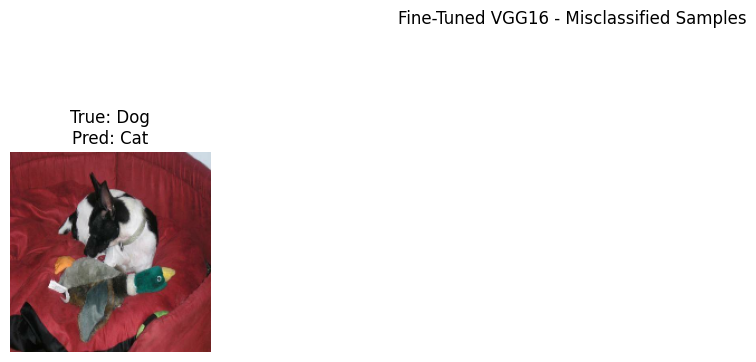

In [132]:
# Function to visualize misclassified samples
def plot_misclassified_samples(images, labels, predictions, misclassified_indices, model_name, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_indices[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))  # Convert Tensor to NumPy array
        plt.title(
            f"True: {'Dog' if labels[idx] else 'Cat'}\nPred: {'Dog' if predictions[idx] else 'Cat'}"
        )
        plt.axis("off")
    plt.suptitle(f"{model_name} - Misclassified Samples")
    plt.show()

# Visualize misclassified samples for Custom CNN
plot_misclassified_samples(test_images, test_labels, custom_predictions, custom_misclassified_indices, "Custom CNN")

# Visualize misclassified samples for Fine-Tuned VGG16
plot_misclassified_samples(test_images, test_labels, vgg16_predictions, vgg16_misclassified_indices, "Fine-Tuned VGG16")


### Detailed Summary of Model Evaluation

#### This evaluation compares the performance of two models: a custom Convolutional Neural Network (CNN) and a fine-tuned VGG16 model, trained and tested on a binary classification task (Cats vs. Dogs). Below is a breakdown of their performance metrics, confusion matrices, and key insights:

1. #### Custom CNN
#### Performance Metrics:

#### Test Accuracy: 81.8%
#### Loss: 0.4094
#### Misclassified Samples: 12

#### True Positives (Cats): 25
#### True Positives (Dogs): 26
#### False Positives (Cats misclassified as Dogs): 4
#### False Positives (Dogs misclassified as Cats): 8

#### Classification Report:

#### Precision:
#### Cats: 0.76
#### Dogs: 0.87
#### Recall:
#### Cats: 0.86
#### Dogs: 0.76
#### F1-Score:
#### Cats: 0.81
#### Dogs: 0.81
#### Weighted Average F1-Score: 0.81
##### Observations:

#### The custom CNN achieves a moderately good accuracy of 81.8%, indicating it can differentiate between cats and dogs to a reasonable extent.
#### However, the recall for dogs (76%) suggests that the model struggles to identify all dog samples correctly, leading to higher false negatives.
#### Precision for cats (76%) also indicates some false positives in classification.
#### The custom CNN’s architecture might benefit from improvements, such as:
#### Adding more convolutional and pooling layers to enhance feature extraction.
#### Employing regularization techniques like dropout to prevent overfitting.
#### Increasing the number of training epochs or using additional training data for better generalization.

2. #### Fine-Tuned VGG16
#### Performance Metrics:

#### Test Accuracy: 97.6%
#### Loss: 1.6183
#### Misclassified Samples: 1

#### True Positives (Cats): 29
#### True Positives (Dogs): 33
#### False Positives (Cats misclassified as Dogs): 0
#### False Positives (Dogs misclassified as Cats): 1
#### Classification Report:

#### Precision:
#### Cats: 0.97
#### Dogs: 1.00
#### Recall:
#### Cats: 1.00
#### Dogs: 0.97
#### F1-Score:
#### Cats: 0.98
#### Dogs: 0.99
#### Weighted Average F1-Score: 0.98
#### Observations:

#### The fine-tuned VGG16 model delivers exceptional performance with a test accuracy of 97.6%.
#### Its near-perfect precision and recall values demonstrate that transfer learning effectively leverages pre-trained weights to generalize well on this dataset.
#### Misclassification is minimal, with only 1 dog sample misclassified.
#### The model’s success highlights the advantage of using a pre-trained network, particularly for smaller datasets where training a model from scratch might not yield comparable results.

#### Comparison and Key Takeaways
#### Custom CNN: While the custom model shows decent performance, its misclassification rate and moderate F1-scores indicate a need for architectural enhancements and possibly more training data.

#### Fine-Tuned VGG16: The VGG16 model, fine-tuned on the same dataset, exhibits remarkable accuracy and significantly outperforms the custom CNN across all metrics. Transfer learning proves to be a robust method, leveraging prior knowledge from large-scale datasets like ImageNet.